In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
%matplotlib inline
from importlib import reload
import depthutil2 as dpu
import graphql_getpoolstat
reload(graphql_getpoolstat)
reload(dpu)
from tqdm import tqdm
from depthutil2 import *

In [2]:
address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'

In [3]:
address='0x5777d92f208679db4b9778590fa3cab3ac9e2168' # usdc dai

In [4]:
address='0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8' # usdc eth

In [5]:
# Load data
filein = 'data/mintburnall_bigquery.csv'
poolstats=graphql_getpoolstat.subgraph_getpoolstats(address)
decimals0=int(poolstats['token0']['decimals'])
decimals1=int(poolstats['token1']['decimals'])
symbol0=poolstats['token0']['symbol']
symbol1=poolstats['token1']['symbol']
feeTier=int(poolstats['feeTier'])
ts=feetier2tickspacing(feeTier)
print(symbol0,decimals0, symbol1, decimals1,feeTier,ts)


df = pd.read_csv(filein, dtype={'amount': float, 'amount0': float, 'amount1': float})
df = df.loc[df.address == address]
df = df.loc[df.amount!=0]
df["date"] = pd.to_datetime(df.block_timestamp).dt.date
df=df.sort_values('block_number')


fileprice='tickprice_%s.csv' % address
if (not(os.path.exists(fileprice))):
    print('getting prices:')
    bndate=df.loc[df.amount!=0].groupby('date').block_number.last()
    bndate.to_csv('tmp_bndate.csv')
    os.system('python3.9 graphql_getprice.py %s %s' % (address,'tmp_bndate.csv'))

dfprice=pd.read_csv(fileprice)[['bn','token0Price','tick']].rename(columns={'bn':'block_number','token0Price':'price','tick':'currenttick'})

# dfprice.plot('block_number','price')

USDC 6 WETH 18 3000 60


In [6]:
# calculate 
# reduce size of range if 1tick spacing
if(ts==1):
    df=LimitTickRange(df,dfprice,nstd=5).copy()
dfl = genLiqRange(df,ts=ts)
dfl['block_timestamp']=pd.to_datetime(dfl.block_timestamp)
dfl['date']=dfl.block_timestamp.dt.date
dfm=pd.merge(dfl,dfprice,on='block_number',how='left').dropna()

dfl=LimitTickRange(dfl,dfprice,nstd=5).copy()

## Comparison of v3 vs equivalent v2 for single date cross-section

In [7]:
dfmS=dfm.loc[dfm.block_number==dfm.block_number.max()]

In [8]:
delta=np.round(np.arange(-.1,.11,.01)/.01)*.01

In [9]:
# v3
depthv3XC=genMarketDepthCrossSection(dfmS,decimals0=decimals0,ts=ts,pctchg=delta).rename(columns={'marketdepth':'v3depth'})

In [10]:
# v2
liqtmp=genLiqRangeXNumeraire(dfmS,tickspacing=ts,decimals0=decimals0,decimals1=decimals1,pricemode=0)

tdl=liqtmp.liqX.sum()
p=liqtmp.p.iloc[0]/(10**(decimals1-decimals0))

depthv2=calcV2DepthfromTDL(total_deposit_locked=tdl,p=p,delta=delta)

<AxesSubplot:xlabel='pct'>

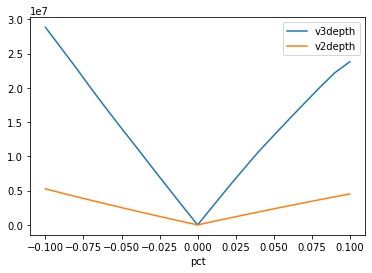

In [11]:
comp=pd.merge(depthv3XC,depthv2,on='pct')
comp.set_index('pct').plot()

In [12]:
comp.loc[comp.pct==.02]

,v3depth,pct,v2depth
12,5.449191e+06,0.02,957423.584163


In [20]:
liqtmp['price_t']=1/(liqtmp.pa/10**(decimals1-decimals0))

<AxesSubplot:xlabel='price_t'>

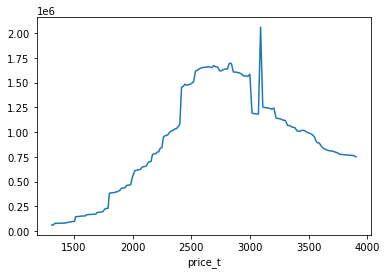

In [24]:
liqtmp.loc[(liqtmp.price_t>liqtmp.price*.5) & (liqtmp.price_t<liqtmp.price*1.5)].set_index('price_t').liqX.plot()

## Time series comparison

In [14]:
md = pipeMarketDepth(address=address,pctchg=[-.02,.02])


USDC 6 WETH 18 3000 60


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]


In [15]:
v2d= getV2EquivalentDepthfromV3(dfm,ts=ts,decimals0=decimals0,decimals1=decimals1,delta=[-.02,.02])

# v2d = pd.DataFrame(v2d.groupby(['date','block_number']).v2depth.sum()).reset_index()

In [16]:
dc=pd.merge(md, v2d,on=['block_number','pct'],how='inner')

<AxesSubplot:xlabel='date_x'>

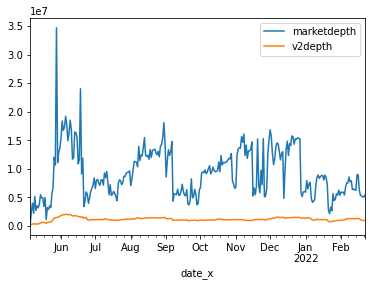

In [17]:
dc.loc[dc.pct==.02].set_index('date_x')[['marketdepth','v2depth']].plot()